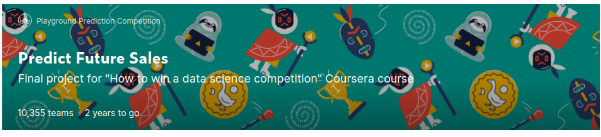


#  Predict Future Sales competition

##  대회 목표: 다음달 모든 제품 및 매장의 총 판매량 예측

### 데이터 구성 

    + sales_train.csv : train set으로 2013년 1월부터 2015년 10월까지의 기록데이터
    + test.csv : test set. store와 item의 2015년 11월 매출 데이터
    + sample_submission.csv : 제출용
    + items.csv : category와 item 정보
    + item_categories.csv : item category 정보
    + shops.csv : shop 정보

#### data columns information 

    + ID : 테스트 세트 내에서 (Shop, Item) 튜플을 나타내는 Id
    + shop_id : 상점의 고유 식별자
    + item_id : 상품의 고유 식별자
    + item_category_id : 항목 카테고리의 고유 식별자
    + item_cnt_day : 판매 된 제품 수입니다. 이 측정 값의 월별 금액을 예측하고 있습니다.
    + item_price : 상품의 현재 가격
    + date  : dd / mm / yyyy 형식의 날짜
    + date_block_num : 편의를 위해 사용되는 연속 된 월 번호. 2013 년 1 월은 0, 2013 년 2 월은 1, ..., 2015 년 10 월은 33입니다.
    + item_name :  항목 이름
    + shop_name : 상점 이름
    + item_category_name : 항목 카테고리 이름


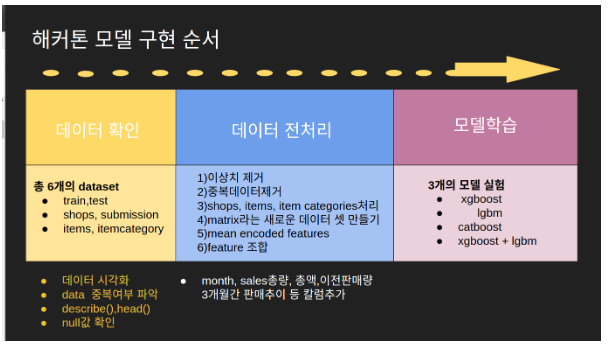

# Libraries

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# **Load data**

In [71]:
test = pd.read_csv('input/test.csv')
train = pd.read_csv('input/sales_train.csv')
shops = pd.read_csv('input/shops.csv')
items = pd.read_csv('input/items.csv')
item_categories = pd.read_csv('input/item_categories.csv')

### 데이터 확인

In [72]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [73]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [74]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [75]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [76]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# data 시각화 

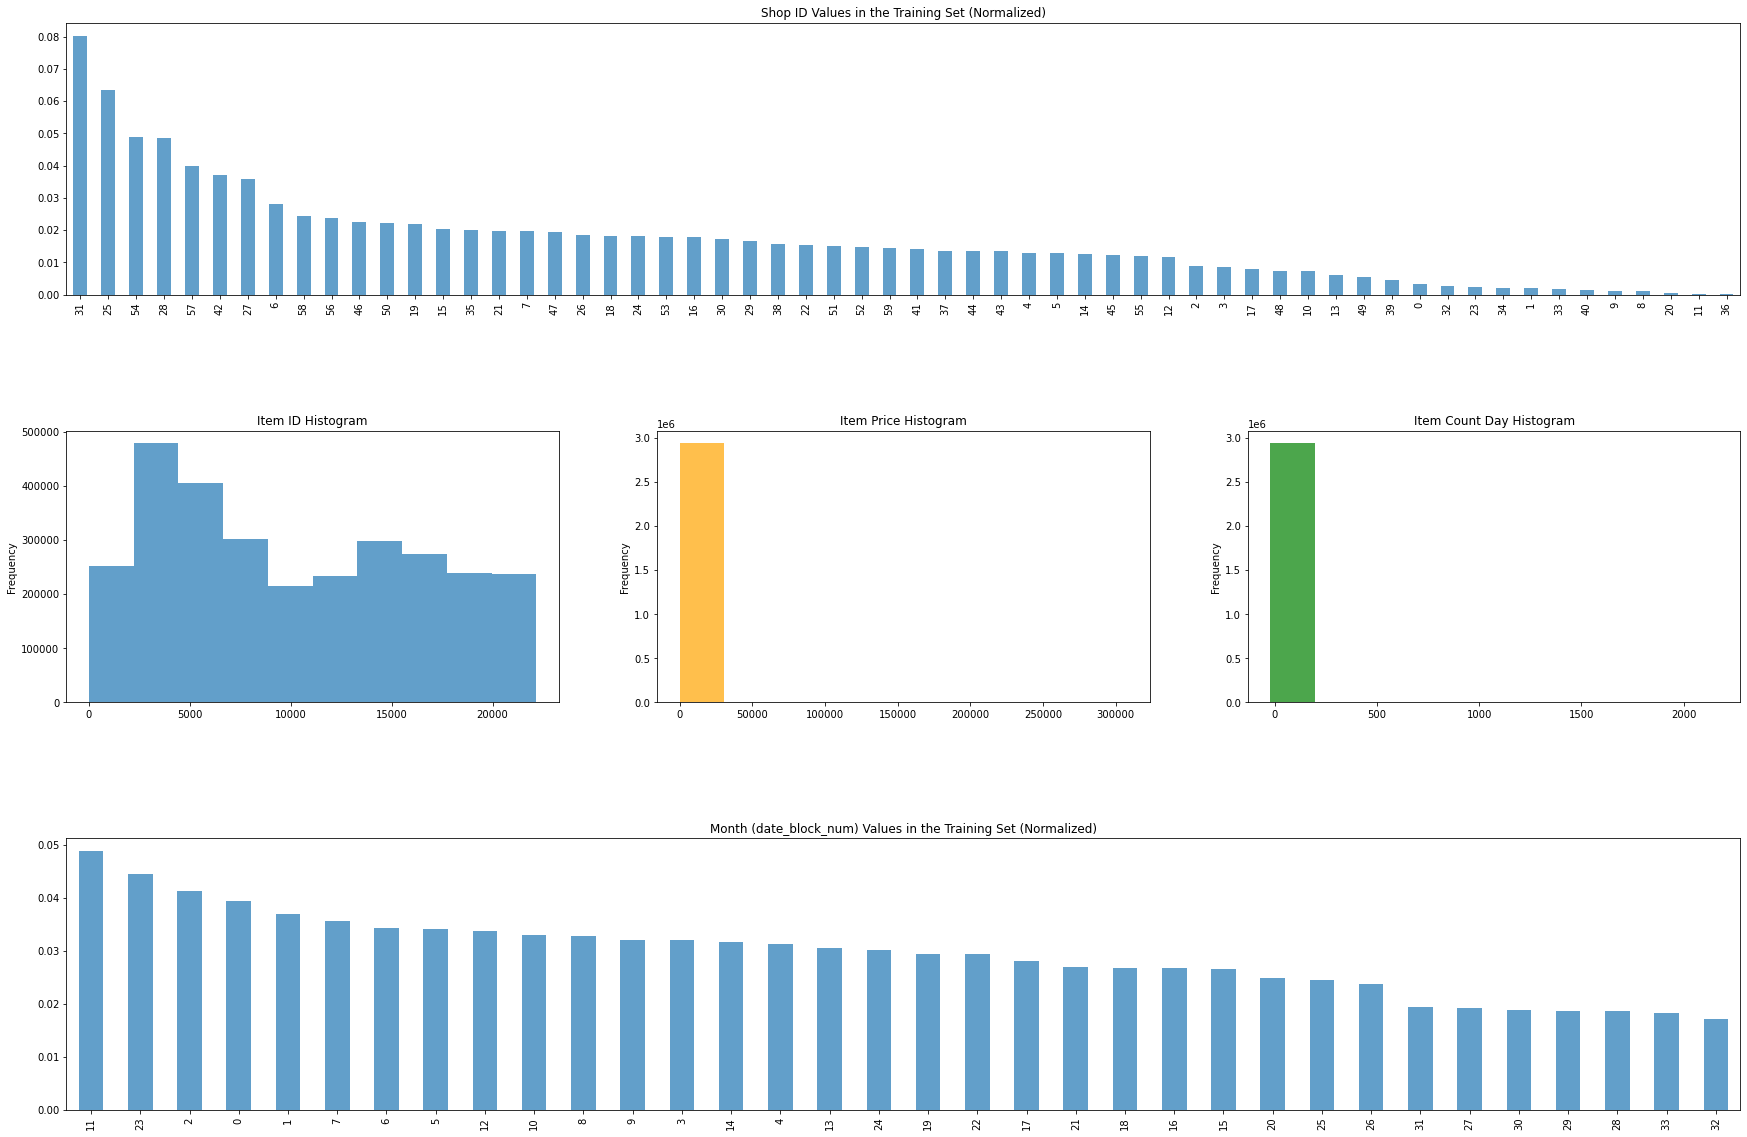

In [77]:
fig = plt.figure(figsize=(30,20))
plt.subplots_adjust(hspace=0.5) #hspace 옵션은 subplot사이의 공간을 얼만큼 둘것인가를 나타냅니다. 

plt.subplot2grid((3,3), (0,0), colspan = 5) # subplot2grid는 일반 그리드 내의 특정 위치에 축을 만들어 냅니다. colspan옵션은 축이 아래쪽으로 확장되는 열의 수를 나타냅니다.
train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)#normalize를 해주면 2만개가 넘던게 0,08이 최대로 변합니다. 
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist', alpha=0.7)#여기서는 hist로 나타낸 이유가 일단 모르겠으면 histo가 편합니다. 얼마나 쌓여있는지 어디에 값이 편향되어있는지 확인하기 좋습니다. 
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist', alpha=0.7, color='orange')#대부분의 값들이 만개정도..?까지 있는것같은데 더 자세히 찍어서 이상치를 확인하는게 좋을 듯합니다. 
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')#애도 이상치가 있어보이네요. 값이 편향되어 있습니다. 
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3) #시작일부터 월별 추이를 나타냅니다. 음...판매량이 점점 떨어지네요..
train['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

In [78]:
# analysis
analysis = train.copy()

## day sales
analysis['day_sales'] = [int(p*q) for p, q in zip(analysis.item_price, analysis.item_cnt_day)]

## month sales
month_sales = np.array(analysis[['date_block_num', 'day_sales']].groupby(['date_block_num']).sum()['day_sales'])
analysis['month_sales'] = month_sales[analysis['date_block_num']]
analysis.head()

## item name and category
name_id = {x.at['item_id']: (x.at['item_name'], x.at['item_category_id']) for ix, x in items.iterrows()}
analysis['item_name'] = [name_id[x][0] for x in analysis['item_id']]
analysis['item_category_id'] = [name_id[x][1] for x in analysis['item_id']]
#cat_id = {x.at['item_category_id']: x.at['item_category_name'] for ix, x in items_cat.iterrows()}
cat_id = {x.at['item_category_id']: x.at['item_category_name'] for ix, x in item_categories.iterrows()}
analysis['item_category'] = [cat_id[x] for x in analysis['item_category_id']]

shop_name = {x.at['shop_id']: x.at['shop_name'] for ix, x in shops.iterrows()}
analysis['shop_name'] = [shop_name[x] for x in analysis['shop_id']]

In [79]:
grp = ['shop_id', 'item_id', 'date_block_num']
analysis['shop_item_cnt_month'] = analysis[['date_block_num', 'item_cnt_day', 'item_id', 'shop_id']].groupby(grp).transform('sum')
analysis.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day_sales,month_sales,item_name,item_category_id,item_category,shop_name,shop_item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0,999,91944419,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",1.0
1,03.01.2013,0,25,2552,899.00,1.0,899,91944419,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",0.0
2,05.01.2013,0,25,2552,899.00,-1.0,-899,91944419,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",0.0
3,06.01.2013,0,25,2554,1709.05,1.0,1709,91944419,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1.0
4,15.01.2013,0,25,2555,1099.00,1.0,1099,91944419,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",1.0


In [80]:
tr = train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
tr['year'] = pd.to_datetime(tr['date']).dt.strftime('%Y')
tr['month'] = pd.to_datetime(tr['date']).dt.strftime('%m')
tr['day'] = pd.to_datetime(tr['date']).dt.strftime('%d')

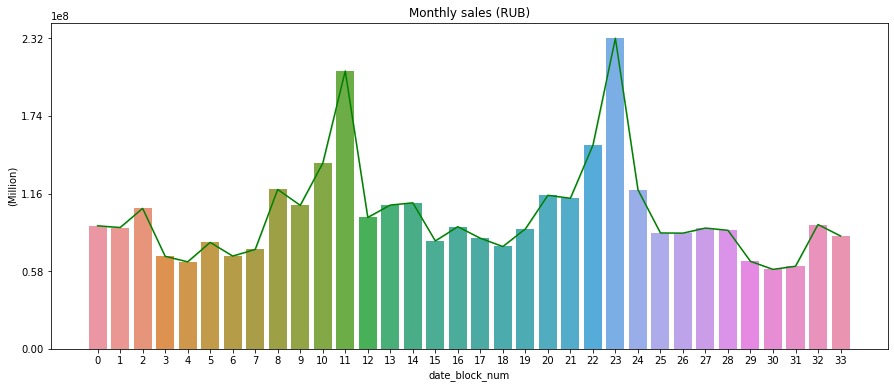

In [81]:
#월별 판매추이 시각화
plt.figure(figsize=(15,6))
ax = plt.subplot()
monthly_sales = sns.barplot(x=analysis.date_block_num, y=analysis.month_sales, ax = ax)
monthly_sales.set_title("Monthly sales (RUB)")
monthly_sales.set_yticks(np.arange(0, analysis.month_sales.max() + 1, analysis.month_sales.max()/4))
monthly_sales.set(ylabel = "(Million)")

ms_line = sns.lineplot(x=analysis.date_block_num , y=analysis.month_sales, ax = ax, color='green')

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecation

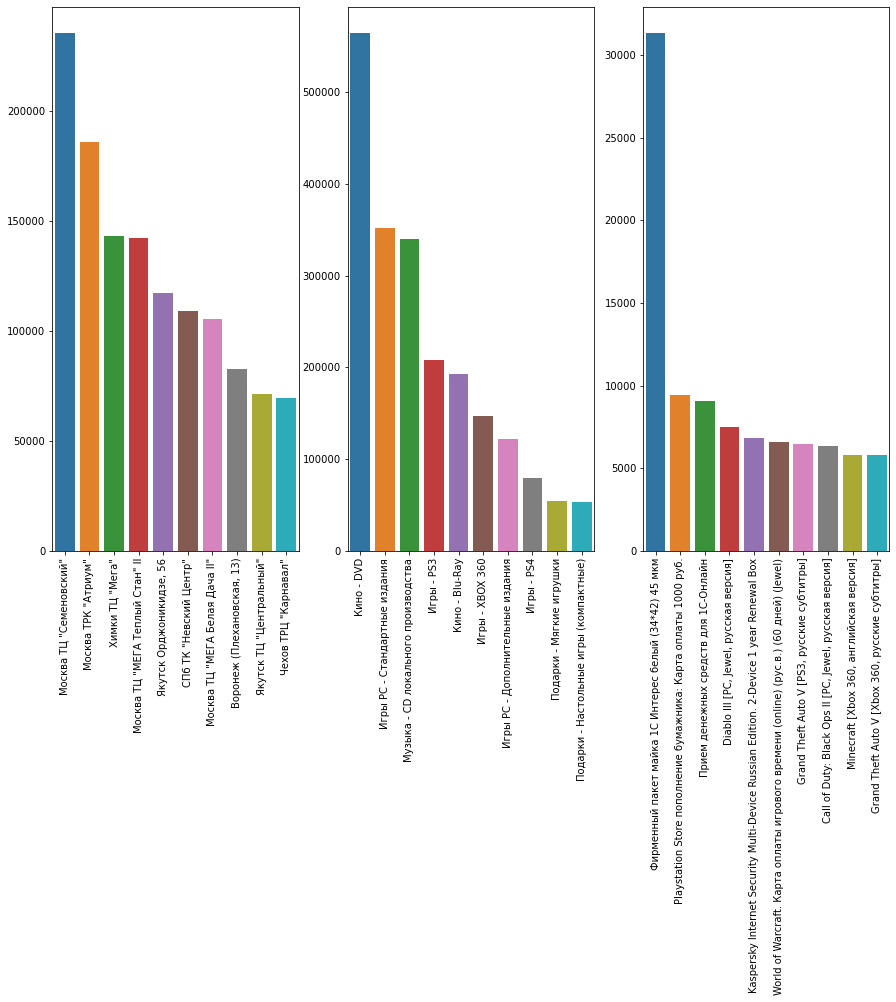

In [82]:
#아이템, 카테고리, 가게 인기 있는 것 알기 
fig = plt.figure(figsize =(15,10))
plt.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

#가게 
plt.subplot(1,3,1)
most_popular_shops = analysis.shop_name.value_counts()[:10]
best_shop_df = analysis.loc[analysis.shop_name == most_popular_shops.keys()[0]]
plt.xticks(rotation = 90)
mps = sns.barplot(x=most_popular_shops.keys(), y=most_popular_shops.values)

#카테고리 
plt.subplot(1,3,2)
most_popular_cats = analysis.item_category.value_counts()[:10]
plt.xticks(rotation = 90)
mpc = sns.barplot(x=most_popular_cats.keys(), y=most_popular_cats.values)

#상품
plt.subplot(1,3,3)
most_popular_items = analysis.item_name.value_counts()[:10]
plt.xticks(rotation = 90)
mpi = sns.barplot(x=most_popular_items.keys(), y=most_popular_items.values)

<AxesSubplot:xlabel='month', ylabel='item_cnt_day'>

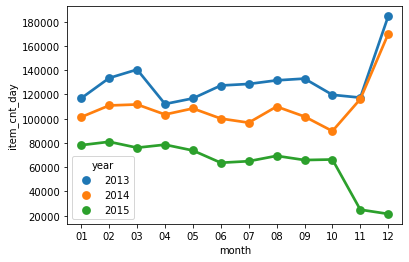

In [83]:
grouped = pd.DataFrame(tr.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=grouped)

<AxesSubplot:xlabel='month', ylabel='item_price'>

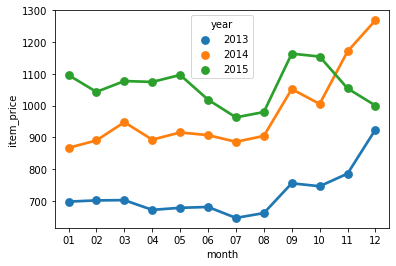

In [84]:
grouped_price = pd.DataFrame(tr.groupby(['year','month'])['item_price'].mean().reset_index())
sns.pointplot(x='month', y='item_price', hue='year', data=grouped_price)

## 데이터셋 preprocessing

---
### 이상치 제거
- item_price을 seaborn으로 시각화한 후 이상치를 확인한다. 

<AxesSubplot:xlabel='item_price'>

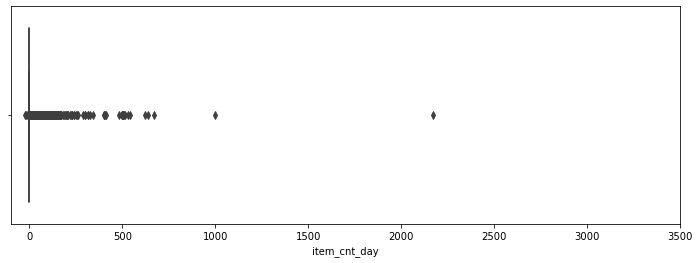

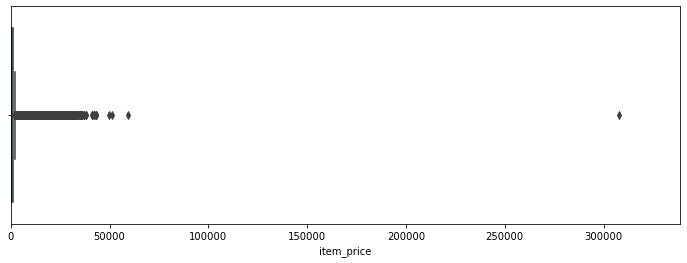

In [8]:
plt.figure(figsize=(12, 4))
plt.xlim(-100, 3500)
sns.boxplot(x=train['item_cnt_day'])
# x의 범위를 상품의 최소부터 최대시켜서 지정 [보기 편하게 1.1 곱]
plt.figure(figsize=(12,4))
plt.xlim(train['item_price'].min(), train['item_price'].max()*1.1)
sns.boxplot(x=train.item_price)

In [9]:
# 상품 가격 100,000 미만 제거, 판매된 상품 1000 미만 넣기 
train = train[train['item_price']<100000]
train = train[train['item_cnt_day']<1001]

<AxesSubplot:xlabel='item_price'>

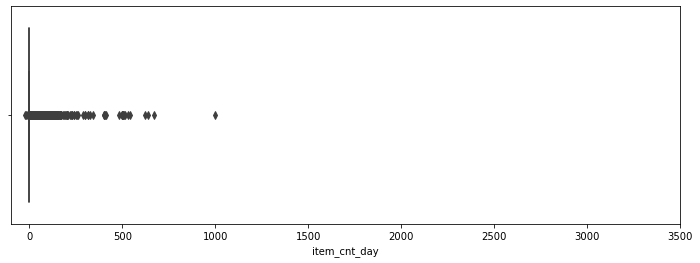

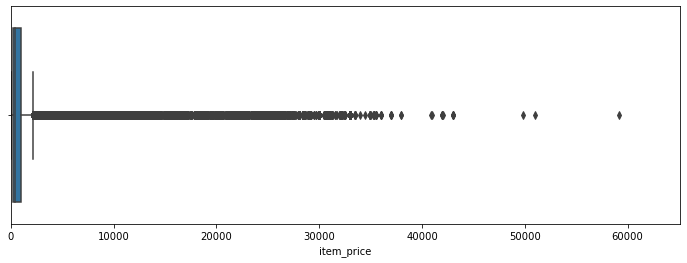

In [10]:
plt.figure(figsize=(12, 4))
plt.xlim(-100, 3500)
sns.boxplot(x=train['item_cnt_day'])
# x의 범위를 상품의 최소부터 최대시켜서 지정 [보기 편하게 1.1 곱]
plt.figure(figsize=(12,4))
plt.xlim(train['item_price'].min(), train['item_price'].max()*1.1)
sns.boxplot(x=train.item_price)

item_price를 100,000을 기준으로 drop된것을 확인할 수 있습니다.

In [11]:
train = train[train['item_price'] > 0]

In [12]:
# 위에서 확인했던 0 미만의 상품 가격 확인 [price가 음수인 경우]
train.loc[(train['item_price']<0) ]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [13]:
# 같은 상품의 비슷한 조건을 가진
median = train[(train.shop_id==32)&(train.item_id==2973)&
               (train.date_block_num==4)&(train.item_price>0)].item_price.median()

In [14]:
train.loc[train.item_price < 0, 'item_price'] = median

---

### 중복 확인
- 중복 확인 or 다른값 변경

중복된 값이 있는지 확인을한 후 해당 값을 변경하는 작업을 한다.

In [15]:
print("train :",sum(train.duplicated()), "  test : ", sum(test.duplicated()))

train : 6   test :  0


In [16]:
print("items :",sum(items.duplicated()), "  item_categories : ", sum(item_categories.duplicated()),
      "   shops : ", sum(shops.duplicated()) )

items : 0   item_categories :  0    shops :  0


In [17]:
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [18]:
train.loc[(train['shop_id']==54) & (train['date_block_num']==0) & (train['item_id']==20130) ]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.0,1.0
76962,05.01.2013,0,54,20130,149.0,1.0


In [19]:
train.drop_duplicates(inplace=True )

In [20]:
# 제거 되었는지 확인
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Shops 데이터 확인
shop_name에 ' ! '가 들어가 있어서 중복된 값이라고 인식 안되었을 수 있다.  
따라서, ' ! '를 뺀후 데이터를 살펴본다.

In [21]:
shops['shop_name'].str.split("!")

0                      [, Якутск Орджоникидзе, 56 фран]
1                      [, Якутск ТЦ "Центральный" фран]
2                                    [Адыгея ТЦ "Мега"]
3                      [Балашиха ТРК "Октябрь-Киномир"]
4                            [Волжский ТЦ "Волга Молл"]
5                              [Вологда ТРЦ "Мармелад"]
6                          [Воронеж (Плехановская, 13)]
7                              [Воронеж ТРЦ "Максимир"]
8                        [Воронеж ТРЦ Сити-Парк "Град"]
9                                   [Выездная Торговля]
10                         [Жуковский ул. Чкалова 39м?]
11                         [Жуковский ул. Чкалова 39м²]
12                                [Интернет-магазин ЧС]
13                                [Казань ТЦ "Бехетле"]
14                            [Казань ТЦ "ПаркХаус" II]
15                               [Калуга ТРЦ "XXI век"]
16                                   [Коломна ТЦ "Рио"]
17                      [Красноярск ТЦ "Взлетка 

! 확인 결과 일부 shop_name간 서로 유사한 경우를 확인할 수 있다.  
0-57  
1-58  
10-11  

In [22]:
# 0에 들어있는 값으로 확인
# shop_name에서 같은 이름을 다르게 부르는것을 확인할 수 있다.
shops.loc[shops['shop_name'].str.contains('Якутск Орджоникидзе')]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57


In [23]:
# 1에 들어있는 값으로 확인
# shop_name에서 같은 이름을 다르게 부르는것을 확인할 수 있다.
shops.loc[shops['shop_name'].str.contains('Якутск ТЦ')]

,shop_name,shop_id
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58


In [24]:
# 10에 들어있는 값으로 확인
# shop_name에서 같은 이름을 다르게 부르는것을 확인할 수 있다.
shops.loc[shops['shop_name'].str.contains('Жуковский ул. Чкалова')]

,shop_name,shop_id
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


위에서 발견한 값은 train, test에서도 그대로 적용되어 있으므로 train, test에서 하나의 shop_id로 변경한다.

In [25]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

---
### Null 체크
missingno 라이브러리의 matrix 함수를 사용하여 데이터에 결측치가 있는지를 확인하겠습니다.

<AxesSubplot:>

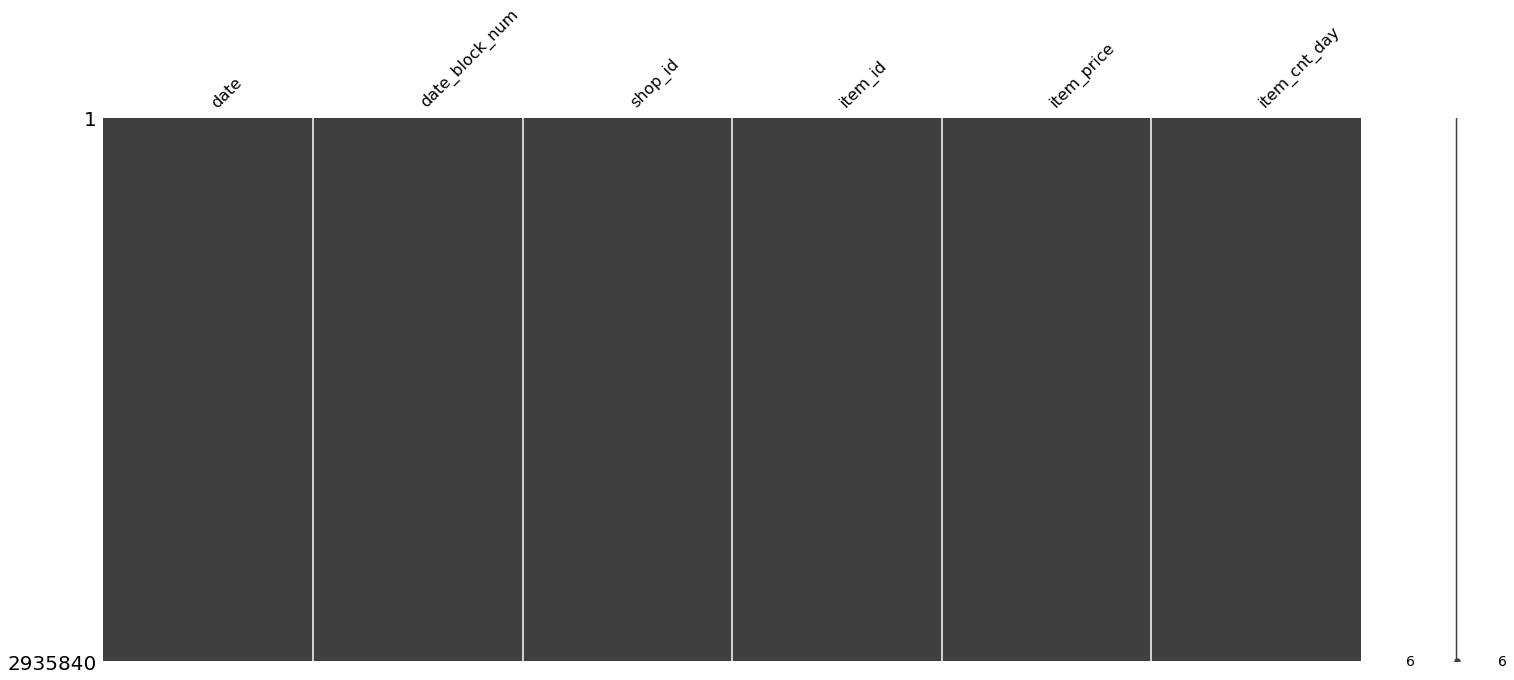

In [26]:
msno.matrix(train)

결측치가 없는것을 확인할 수 있지만, 그래도 모든 변수에 걸쳐서 다시 확인하겠습니다.

In [27]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [28]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

구해야 하는 테스트 데이터 value 확인

In [29]:
# shop_id와 각 shop 별 item 확인 
test['shop_id'].value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
11    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

test 데이터에는 42개의 shop_id가 있고 각 shop마다 5100개의 item이 있다.

train에는 있는 item이 test에는 없을 수 있다. 이 반대의 경우도 가능  
따라서, 다른 item_id가 있는지 확인한다.

In [30]:
# test에는 있고 train에선 없는 경우
len(set(test.item_id) - set(train.item_id))

363

test에는 있지만 train에는 없는 item_id 총 363개를 확인할 수 있다. 이것은 train의 item 데이터와 test에 있는 모든 item 데이터가 같지 않다는 것을 뜻한다. 

따라서, train에 없는 363개의 item은 판매된 개수를 0으로 예측해야한다.

In [31]:
len(list(set(test.item_id))), len(test)

(5100, 214200)

---

### Monthly Sales matrix 생성

363 개 항목이 train에 없는 데이터이다. 따라서, 테스트 세트의 대부분의 항목에 대한 target 값은 0이 되어야 한다. 반면에 train 세트에는 과거에 판매 또는 반품 된 쌍만 포함됩니다. 이것을 다시 생각해보면 월별 매출을 계산하고 한 달 동안 각 고유 쌍에 대해 매출을 0으로 확장하는 것이 된다.   
이런 식으로 train 데이터를 학습시켜서 test 데이터의 target을 구한다.

- date_block_num의 값을 기준으로 sales matrix를 생성한다.

In [32]:
# date_block_num의 가장 큰 값은 33이다.
train['date_block_num'].max()

33

In [33]:
sales_matrix = []
cols = ['shop_id','item_id', 'date_block_num']
# date_block_num을 기준으로 shope별 item이 판매된 matrix를 생성한다.
matrix = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    matrix.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    
# np.vstack으로 sales_matrix 행을 추가한다.
matrix = pd.DataFrame(np.vstack(matrix), columns=cols,dtype=np.int32)

In [34]:
matrix[:5]

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [35]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [36]:
# 'item_cnt_day': 'sum'을 기준으로 groupby 한다.
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              2       27               1.0
                       33               1.0
                       317              1.0
                       438              1.0
                       471              2.0

In [37]:
group.columns = ['item_cnt_month']
# 인덱스 재설정
group.reset_index(inplace=True)

In [38]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


group의 값을 클립(0 ~ 30)지정 합니다 이렇게하면 train targetd이 테스트 예측과 유사하게 됩니다.

나중에 테스트 세트와 연결 한 후 downcasting을 피하기 위해 item_cnt_month에 int 대신 float를 사용합니다. int16이면 NaN 값과 연결 한 후에는 int64가되지만 foat16은 NaN을 사용해도 float16이됩니다.

In [39]:
matrix = pd.merge(matrix, group, on=cols, how='left')

matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) 
                                .astype(np.float16))
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


### matrix에 테스트 데이터 붙이기

In [40]:
# 기존 train에는 33까지의 date_block_num이 있다.
# 테스트 데이터를 새로운 date_block_num으로 확장시킨다.
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [41]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

## Feature engineering

### Shops 전처리
각 shop_name은 도시 이름으로 시작합니다.  
각 범주에는 이름에 유형과 하위 유형이 포함됩니다.  

* shops에 있는 데이터에서 앞부분이 city를 의미하니 따로 꺼내서 사용한다.  
* city 마다 코드를 준다. [실제 지도의 값으로 준다.]  
* map에 따라서 city를 4개의 값으로 구분한다.  

In [42]:
# shops에 대한 전처리

# 데이터들을 확인했을때 가장 앞에 있는 데이터가 도시를 뜻하니 ' '를 기준으로 분리한 후
# 가장 앞에 있는 데이터를 city를 의미하는 column데이터로 생성한다. 
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
# ! 특수문자가 들어간 도시에서 특수문자를 제거한다.
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'

In [43]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,якутск
2,"Адыгея ТЦ ""Мега""",2,адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,балашиха
4,"Волжский ТЦ ""Волга Молл""",4,волжский


문자열 데이터인 shops를 수식 데이터로 변환하는 Encoding 작업 진행한다.

In [44]:
#  문자열 데이터인 shop_nam, city를 삭제한다.
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

지도의 `위도`와 `경도` 정보를 활용하여 city 값을 조정한다.

In [45]:
coordis = dict()
coordis['якутск'] = (62.028098, 129.732555, 4)
coordis['адыгея'] = (44.609764, 40.100516, 3)
coordis['балашиха'] = (55.8094500, 37.9580600, 1)
coordis['волжский'] = (53.4305800, 50.1190000, 3)
coordis['вологда'] = (59.2239000, 39.8839800, 2)
coordis['воронеж'] = (51.6720400, 39.1843000, 3)
coordis['выездная'] = (0, 0, 0)
coordis['жуковский'] = (55.5952800, 38.1202800, 1)
coordis['интернет-магазин'] = (0, 0, 0)
coordis['казань'] = (55.7887400, 49.1221400, 4)
coordis['калуга'] = (54.5293000, 36.2754200, 4)
coordis['коломна'] = (55.0794400, 38.7783300, 4)
coordis['красноярск'] = (56.0183900, 92.8671700, 4)
coordis['курск'] = (51.7373300, 36.1873500, 3)
coordis['москва'] = (55.7522200, 37.6155600, 1)
coordis['мытищи'] = (55.9116300, 37.7307600, 1)
coordis['н.новгород'] = (56.3286700, 44.0020500, 4)
coordis['новосибирск'] = (55.0415000, 82.9346000, 4)
coordis['омск'] = (54.9924400, 73.3685900, 4)
coordis['ростовнадону'] = (47.2313500, 39.7232800, 3)
coordis['спб'] = (59.9386300, 30.3141300, 2)
coordis['самара'] = (53.2000700, 50.1500000, 4)
coordis['сергиев'] = (56.3000000, 38.1333300, 4)
coordis['сургут'] = (61.2500000, 73.4166700, 4)
coordis['томск'] = (56.4977100, 84.9743700, 4)
coordis['тюмень'] = (57.1522200, 65.5272200, 4)
coordis['уфа'] = (54.7430600, 55.9677900, 4)
coordis['химки'] = (55.8970400, 37.4296900, 1)
coordis['цифровой'] = (0, 0, 0)
coordis['чехов'] = (55.1477000, 37.4772800, 4)
coordis['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coordi_1'] = shops['city'].apply(lambda x: coordis[x][0])
shops['city_coordi_2'] = shops['city'].apply(lambda x: coordis[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coordis[x][2])

shops = shops[['shop_id', 'city_code', 'city_coordi_1', 'city_coordi_2', 'country_part']]

In [46]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')

---
### item_categories 전처리

상품의 카테고리에서 2개의 단어가 ( - )으로 묶여 있다.


* Item category
* More common item category

In [47]:
#  item_categories 확인
# 상품의 카테고리에서 2개의 단어가 ( - )으로 묶여 있는것을 확인할 수 있다.
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [48]:
# Аксессуары : 부속품
# арнитуры : 헤드셋 
# category를 보면 뒤쪽에 물품의 이름이 나오고 앞 부분엔 어떤 종류에 속하는지를 나타난다.
# 그렇지만 일부 품목의 경우 앞뒤가 바껴있는 경우가 있어와 
# 비슷한 카테고리의 속하는 해당 부분을 dict()로 미리 만들고
# mapping 시켜서 `PC - Гарнитуры/Наушники` -> Аксессуары   PC와 같은 형식으로 만든다.

map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }
# item_category_id 기준 병합
items = pd.merge(items, item_categories, on='item_category_id')

# - 기준으로 자르기
items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
# map_dict 매핑 
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)

# 위에서 카테고리를 2가지의 카테고리로 분류한 후 Label Encoder해서 수식화 한다. 
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])

# 필요한 부분만 남긴다.
items = items[['item_id', 'item_category_common', 'item_category_code']]

In [49]:
items.head()

,item_id,item_category_common,item_category_code
0,0,11,40
1,2,11,40
2,3,11,40
3,4,11,40
4,5,11,40


In [50]:
matrix = pd.merge(matrix, items, on=['item_id'], how='left')

### 날짜 정보 전처리

- Weekends count 열 생성 (4 or 5)의 값으로 구성한다.  [  weeknd_count  ]
- 해당 달에 맞는 일자 값을 넣어준다.   [ days_in_month ]

In [51]:
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

matrix['weeknd_count'] = matrix['date_block_num'].apply(lambda x: map_dict[x][0])
matrix['days_in_month'] = matrix['date_block_num'].apply(lambda x: map_dict[x][1])

In [52]:
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coordi_1,city_coordi_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,37,4,31
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,58,4,31
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,58,4,31
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,56,4,31
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,59,4,31


### 기존 feature와 다양한 조합의 itreaction features

- 처음 구매한 item열을 생성
- 이전에 shops에서 구매했 정보를 담은 열 생성

In [53]:
first_item_block = matrix.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = matrix[matrix['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [54]:
matrix = pd.merge(matrix, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
matrix = pd.merge(matrix, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

matrix['first_date_block_num'].fillna(100, inplace=True)
matrix['shop_item_sold_before'] = (matrix['first_date_block_num'] < matrix['date_block_num']).astype('int8')
matrix.drop(['first_date_block_num'], axis=1, inplace=True)

matrix['item_first_interaction'].fillna(0, inplace=True)
matrix['shop_item_sold_before'].fillna(0, inplace=True)
 
matrix['item_first_interaction'] = matrix['item_first_interaction'].astype('int8')  
matrix['shop_item_sold_before'] = matrix['shop_item_sold_before'].astype('int8') 

### 이전 판매량 계산하기 
matrix 매트릭스에 이전 판매량을 계산하여 넣어준다.

In [55]:
def lag_feature(matrix, lags, col):
    tmp = matrix[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        matrix = pd.merge(matrix, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        matrix[col+'_lag_'+str(i)] = matrix[col+'_lag_'+str(i)].astype('float16')
    return matrix

In [56]:
# 지난 3달의 판매 데이터를 넣어준다.
matrix = lag_feature(matrix, [1, 2, 3], 'item_cnt_month')

In [57]:
#Add avg shop/item price
# shops의 평균 item 가격열을 생성하고 lag_feature로 이전 달의 정보도 만든다.

index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
matrix = pd.merge(matrix, group, on=index_cols, how='left')

matrix['avg_shop_price'] = (matrix['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


matrix = pd.merge(matrix, group, on=index_cols, how='left')
matrix['avg_item_price'] = (matrix['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

matrix['item_shop_price_avg'] = (matrix['avg_shop_price'] - matrix['avg_item_price']) / matrix['avg_item_price']
matrix['item_shop_price_avg'].fillna(0, inplace=True)

matrix = lag_feature(matrix, [1, 2, 3], 'item_shop_price_avg')
matrix.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)

### Mean encoded features
**Target encoding**

In [58]:
#Add target encoding for items for last 3 months 
# 해당 target item을 encoding한다 
#  date_block 값 기준으로 mean 구하기
item_id_target_mean = matrix.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
matrix = pd.merge(matrix, item_id_target_mean, on=['date_block_num','item_id'], how='left')

matrix['item_target_enc'] = (matrix['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

matrix = lag_feature(matrix, [1, 2, 3], 'item_target_enc')
matrix.drop(['item_target_enc'], axis=1, inplace=True)

In [59]:
# city와 item을 기준으로 lag_feacture한다.
item_id_target_mean = matrix.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
matrix = pd.merge(matrix, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

matrix['item_loc_target_enc'] = (matrix['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

matrix = lag_feature(matrix, [1, 2, 3], 'item_loc_target_enc')
matrix.drop(['item_loc_target_enc'], axis=1, inplace=True)

In [60]:
# item과 shop을 기준으로 lag_feacture한다.

item_id_target_mean = matrix.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

matrix = pd.merge(matrix, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

matrix['item_shop_target_enc'] = (matrix['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

matrix = lag_feature(matrix, [1, 2], 'item_shop_target_enc')
matrix.drop(['item_shop_target_enc'], axis=1, inplace=True)

### Extra interaction feature 조합 
- 위에서 생성한 item_first_interaction을 가지고 조합을 진행한다.

In [61]:
# 위에서 생성한 item_first_interaction의 평균을 구한다.
item_id_target_mean = matrix[matrix['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

matrix = pd.merge(matrix, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

matrix['new_item_cat_avg'] = (matrix['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

matrix = lag_feature(matrix, [1, 2, 3], 'new_item_cat_avg')
matrix.drop(['new_item_cat_avg'], axis=1, inplace=True)

In [62]:
# 위에서 생성한 item_first_interaction를 shop의 평균으로 추가해 구한다.

item_id_target_mean = matrix[matrix['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

matrix = pd.merge(matrix, item_id_target_mean, on=['date_block_num','item_category_code', 'shop_id'], how='left')

matrix['new_item_shop_cat_avg'] = (matrix['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

matrix = lag_feature(matrix, [1, 2, 3], 'new_item_shop_cat_avg')
matrix.drop(['new_item_shop_cat_avg'], axis=1, inplace=True)

유사한 항목에 대한 지난 3 개월 동안의 판매 추가 (ID = item_id-1 인 항목, 다소 까다로운 기능이지만 측정 항목이 크게 증가 합니다.)

In [63]:
def lag_feature_adv(matrix, lags, col):
    tmp = matrix[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        matrix = pd.merge(matrix, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        matrix[col+'_lag_'+str(i)+'_adv'] = matrix[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return matrix

matrix = lag_feature_adv(matrix, [1, 2, 3], 'item_cnt_month')

3번째달가지의 정보는 matrix에서 제거하고 진행한다.

In [64]:
matrix.fillna(0, inplace=True)
matrix = matrix[(matrix['date_block_num'] > 4)]
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coordi_1,city_coordi_2,country_part,item_category_common,...,item_shop_target_enc_lag_2,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv
1872720,30,11496,5,8.0,0.0,13,55.75222,37.61556,1,11,...,20.0,0.665527,0.986816,0.000000,1.0,1.151367,0.000000,2.0,0.0,0.0
1872721,30,11244,5,1.0,0.0,13,55.75222,37.61556,1,11,...,0.0,0.665527,0.986816,0.643066,1.0,1.151367,0.644043,0.0,0.0,0.0
1872722,30,11388,5,2.0,0.0,13,55.75222,37.61556,1,5,...,1.0,1.088867,0.021744,0.478271,0.0,0.000000,0.666504,0.0,0.0,0.0
1872723,30,11249,5,1.0,0.0,13,55.75222,37.61556,1,11,...,0.0,0.665527,0.986816,0.643066,1.0,1.151367,0.644043,0.0,0.0,0.0
1872724,30,8081,5,1.0,0.0,13,55.75222,37.61556,1,13,...,1.0,0.139648,0.036224,0.067017,0.0,0.083313,0.166626,0.0,0.0,1.0


In [65]:
# 학습에 사용되는 features
matrix.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'city_code', 'city_coordi_1', 'city_coordi_2', 'country_part',
       'item_category_common', 'item_category_code', 'weeknd_count',
       'days_in_month', 'item_first_interaction', 'shop_item_sold_before',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'item_target_enc_lag_1',
       'item_target_enc_lag_2', 'item_target_enc_lag_3',
       'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2',
       'item_loc_target_enc_lag_3', 'item_shop_target_enc_lag_1',
       'item_shop_target_enc_lag_2', 'new_item_cat_avg_lag_1',
       'new_item_cat_avg_lag_2', 'new_item_cat_avg_lag_3',
       'new_item_shop_cat_avg_lag_1', 'new_item_shop_cat_avg_lag_2',
       'new_item_shop_cat_avg_lag_3', 'item_cnt_month_lag_1_adv',
       'item_cnt_month_lag_2_adv', 'item_cnt_month_lag_3_adv'],
 

In [66]:
#Save dataset
matrix.drop(['ID'], axis=1, inplace=True, errors='ignore')
matrix.to_pickle('pickle/matrix.pkl')

# Train model

In [67]:
matrix = pd.read_pickle('pickle/matrix.pkl')
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9255284 entries, 1872720 to 11128003
Data columns (total 37 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   shop_id                      int32  
 1   item_id                      int32  
 2   date_block_num               int32  
 3   item_cnt_month               float16
 4   city_code                    int64  
 5   city_coordi_1                float64
 6   city_coordi_2                float64
 7   country_part                 int64  
 8   item_category_common         int64  
 9   item_category_code           int64  
 10  weeknd_count                 int64  
 11  days_in_month                int64  
 12  item_first_interaction       int8   
 13  shop_item_sold_before        int8   
 14  item_cnt_month_lag_1         float16
 15  item_cnt_month_lag_2         float16
 16  item_cnt_month_lag_3         float16
 17  item_shop_price_avg_lag_1    float16
 18  item_shop_price_avg_lag_2    float1

In [68]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del matrix
del group

In [69]:
import gc # 메모리 관리 모듈
gc.collect();

### LightGBM

In [ ]:
feature_name = X_train.columns.tolist()

# 0.88
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code'
]

evals_result = {}
lgb_model = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_valid), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 200)

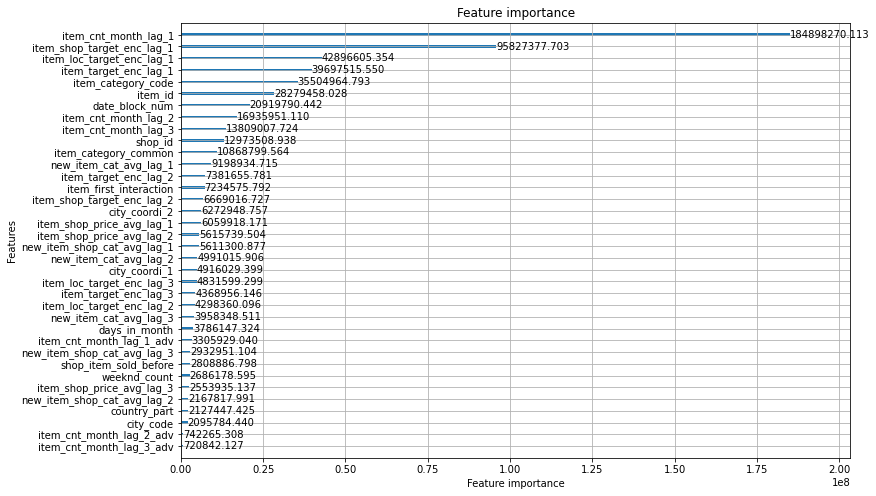

In [78]:
lgb.plot_importance(
    lgb_model, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [ ]:
test = pd.read_csv('input/test.csv')
Y_pred = lgb_model.predict(X_valid).clip(0, 20)
Y_test = lgb_model.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('gbm_submission_best_trial.csv', index=False)

In [84]:
lgb_pred = Y_pred
lgb_test = Y_test

In [ ]:
# 메모리 부족하기 때문에 모델 제거
del lgb_model
gc.collect

## xgboost

In [86]:
import xgboost as xgb

In [87]:
Best_trial = {'alpha': 0.01563845128469084, 'colsample_bytree': 0.7,
             'subsample': 0.7,'n_estimators': 50, 'learning_rate': 0.2,'max_depth': 15,
             'random_state': 1, 'min_child_weight': 257}

In [ ]:
feature_name = X_train.columns.tolist()

xgb_model = xgb.XGBRegressor(**Best_trial)
xgb_model.fit(
    X_train[feature_name],
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_valid,Y_valid)],
    early_stopping_rounds=20,
    verbose=False)

In [ ]:
test = pd.read_csv('input/test.csv')
xgb_pred = xgb_model.predict(X_valid).clip(0, 20)
xgb_test = xgb_model.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": xgb_test
})
submission.to_csv('gbm_submission_best_trial.csv', index=False)

In [ ]:
test = pd.read_csv('input/test.csv')
results = [x*0.66 + y*0.34 for x, y in zip(xgb_test,lgb_test)]
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": results
})
submission.to_csv('gbm_submission_best_trial.csv', index=False)

In [78]:
del xgb_model
gc.collect()

49